# What is Transfer Learning?

The hierarchical nature of feature maps allows the network to progressively understand and represent the visual content of an image. Each layer's feature map acts as a filter that specializes in detecting certain aspects of the input, contributing to the network's ability to identify and classify diverse visual patterns.


**Pre-trained Model:**
* Start with a neural network model that has been pre-trained on a large dataset for a specific task, often on a challenging problem like image classification. Popular models for this include VGG, ResNet, and Inception.

**Feature Extraction:**
* Use the pre-trained model as a feature extractor. Extract features from the intermediate layers of the model that capture general and hierarchical representations of the input data. These features are expected to be useful for a broad range of tasks.

**New Task:**
* Customize the last few layers of the pre-trained model to fit the requirements of your specific task. Replace the final classification layer with a new one suitable for your target problem.

**Fine-tuning:**
* Optionally, fine-tune the entire model on your dataset. This involves updating the weights of the pre-trained layers along with the newly added layers using a smaller learning rate to adapt the model to the new task.

## Transfer learning offers several advantages in deep learning: ##

**Data Efficiency:**
* Transfer learning is particularly beneficial when you have limited labeled data for your specific task. By leveraging knowledge from a pre-trained model, you can achieve good performance with less data.

**Computation Efficiency:**
* Training a deep neural network from scratch can be computationally expensive. Transfer learning allows you to save computational resources by starting with a model that has already learned useful representations.

**Improved Generalization:**
* Pre-trained models have typically learned rich features from diverse datasets, contributing to better generalization on a new task.


Transfer learning is widely used in various domains such as computer vision, natural language processing, and speech recognition, providing a powerful approach for building effective models, especially in scenarios with limited labeled data.


**In this notebook i will apply vgg16 pretrain model on brain mri classification**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Set Constant

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 # This means it's a rgb image which have 3 channels

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5712 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names


['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3]


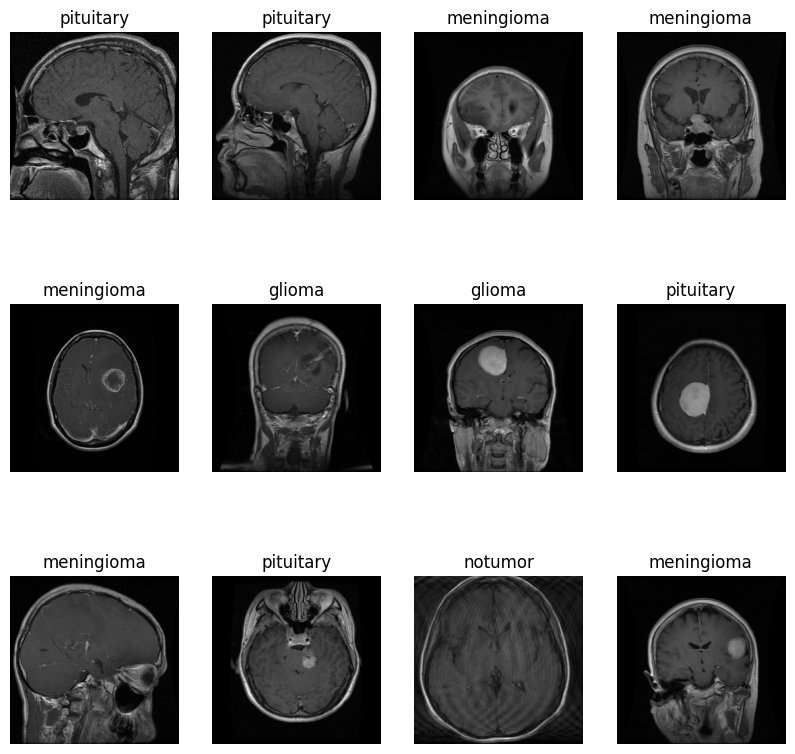

In [7]:
plt.figure(figsize=(10,10))

for image_batch, lables_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [8]:
def get_partition_data(ds, train_split = 0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split) == 1
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds
train_ds, test_ds, val_ds= get_partition_data(dataset)

In [9]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

143
19
17


# Chach Shuffle And Prefetch Data

In [10]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(0.1 / 256)
])

# Data Augmentation

In [12]:
data_augmentation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

# Import Pretrain Model VGG16

In [14]:
from keras.applications.vgg16 import VGG16

In [15]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3))

58889256/58889256 [==============================] - 2s 0us/step


In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

# Adding Connected Layes to vgg16

In [36]:
n_classes = 4
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout, BatchNormalization
model = Sequential()
resize_and_rescale
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(n_classes,activation='sigmoid'))

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # or 'val_accuracy' depending on your goal
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)  

In [38]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                      

In [39]:
conv_base.trainable = False # disable convolustion layers for training


In [40]:
model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics=['accuracy']
                   )

In [41]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds,callbacks=early_stopping)

Epoch 1/30
143/143 [==============================] - 67s 421ms/step - loss: 0.5542 - accuracy: 0.8068 - val_loss: 0.3052 - val_accuracy: 0.8934
Epoch 2/30
143/143 [==============================] - 58s 367ms/step - loss: 0.3689 - accuracy: 0.8715 - val_loss: 0.2359 - val_accuracy: 0.9118
Epoch 3/30
143/143 [==============================] - 59s 373ms/step - loss: 0.3206 - accuracy: 0.8940 - val_loss: 0.2242 - val_accuracy: 0.9228
Epoch 4/30
143/143 [==============================] - 59s 375ms/step - loss: 0.2853 - accuracy: 0.9036 - val_loss: 0.2077 - val_accuracy: 0.9283
Epoch 5/30
143/143 [==============================] - 60s 375ms/step - loss: 0.2745 - accuracy: 0.9082 - val_loss: 0.2732 - val_accuracy: 0.9228
Epoch 6/30
143/143 [==============================] - 59s 373ms/step - loss: 0.2518 - accuracy: 0.9136 - val_loss: 0.3719 - val_accuracy: 0.9393
Epoch 7/30
143/143 [==============================] - 59s 376ms/step - loss: 0.2409 - accuracy: 0.9195 - val_loss: 0.5760 - val_ac

In [42]:
model.evaluate(test_ds)

19/19 [==============================] - 8s 169ms/step - loss: 0.2056 - accuracy: 0.9375


[0.20564880967140198, 0.9375]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

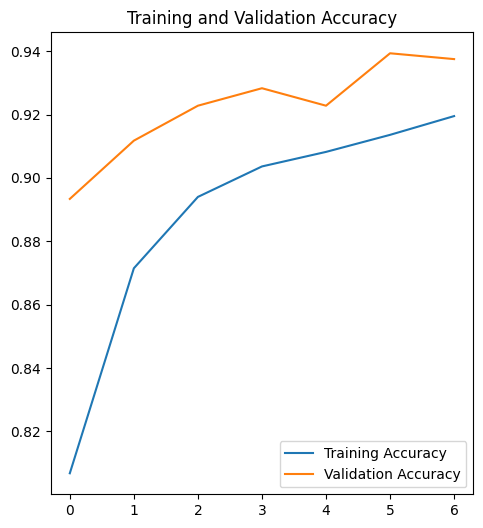

In [45]:
Epochs = len(acc)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc, label='Training Accuracy')
plt.plot(range(Epochs),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



**In this project, I leveraged the power of transfer learning by utilizing the pre-trained VGG16 model. Without training the entire model from scratch, I achieved an impressive 93% accuracy on the test data. This underscores the effectiveness of transfer learning in capturing and utilizing valuable features learned from a diverse dataset.**

**In contrast, when I experimented with a custom model using Keras parameter tuning in the same project, the accuracy reached around 83%. This performance comparison highlights the superior capability of transfer learning in image classification tasks, demonstrating its potential to yield higher accuracy with minimal training effort**